# Importing libraries and loading data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
# Load the dataset
current_path = os.getcwd()
parent_folder = os.path.dirname(current_path)
data_file_path = os.path.join(parent_folder, "Data", "005930.KS_weekly.csv") # import weekly data

df = pd.read_csv(str(data_file_path))

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Checking duplicates and empty entries

In [20]:
df = df[~df.index.duplicated()]

In [21]:
df.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [22]:
df.dropna(inplace=True)


# Data Analysis


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2018-12-31 to 2025-02-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       321 non-null    float64
 1   High       321 non-null    float64
 2   Low        321 non-null    float64
 3   Close      321 non-null    float64
 4   Adj Close  321 non-null    float64
 5   Volume     321 non-null    float64
dtypes: float64(6)
memory usage: 17.6 KB
None

Data Description:
               Open          High           Low        Close     Adj Close  \
count    321.000000    321.000000    321.000000    321.00000    321.000000   
mean   64121.339564  65683.956386  62565.732087  64066.35514  59895.032941   
std    12312.175291  12481.302250  12026.239288  12175.65471  12804.068612   
min    38000.000000  39400.000000  36850.000000  38750.00000  33061.843750   
25%    55200.000000  56800.000000  53400.000000  55000.00000  50337.707031   
50%    63400

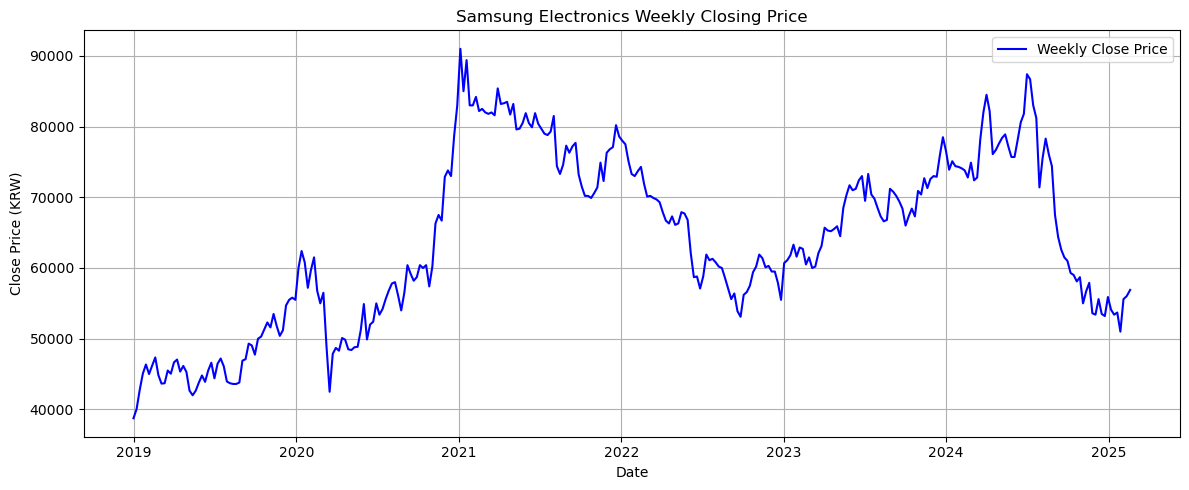

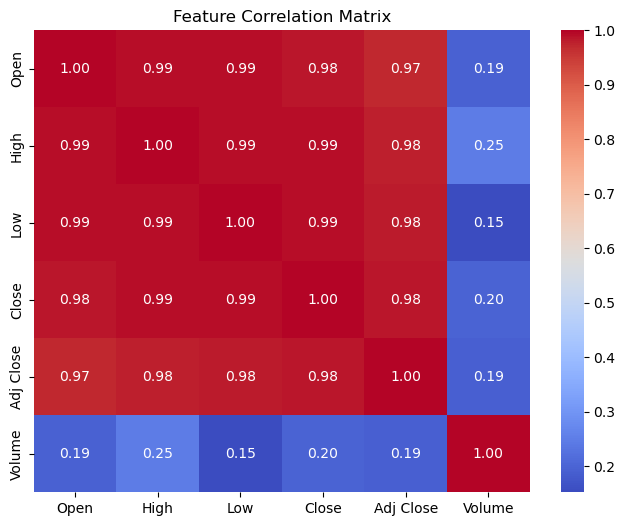

In [23]:
print("\nData Info:")  # viewing data info
print(df.info())
print("\nData Description:")
print(df.describe())

# close price
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Weekly Close Price', color='blue')
plt.title('Samsung Electronics Weekly Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Corr heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


# Check for skewness

# Feature Engineering

In [24]:
# Rolling averages (shifted to avoid future info)
df['Close_ma3'] = df['Close'].rolling(window=3).mean().shift(1)
df['Close_ma5'] = df['Close'].rolling(window=5).mean().shift(1)
df['Volume_ma3'] = df['Volume'].rolling(window=3).mean().shift(1)
df['Volume_ma5'] = df['Volume'].rolling(window=5).mean().shift(1)

df['Close_std3'] = df['Close'].rolling(window=3).std().shift(1)
df['Close_std5'] = df['Close'].rolling(window=5).std().shift(1)

df['Return_1w'] = df['Close'].pct_change(1).shift(1)
df['Return_3w'] = df['Close'].pct_change(3).shift(1)

#drop NaN values that could have been created
df.dropna(inplace=True)

# Creating Target Variable

In [25]:
df['Next'] = df['Close'].shift(-1)
df['Direction'] = (df['Next'] > df['Close']).astype(int)

# Features and target

In [26]:
feature_cols = [
    'Close_ma3', 'Close_ma5',
    'Volume_ma3', 'Volume_ma5',
    'Close_std3', 'Close_std5',
    'Return_1w', 'Return_3w', 'Close', 'Open', 'High', 'Low'
]
X = df[feature_cols]
y = df['Direction']

# Create data train and testing split

In [27]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Basic ML models

## Linear regression

In [28]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

## Random Forest

In [29]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}


In [30]:
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=15, cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
joblib.dump(best_rf, "../artifact/model_1w.pkl")

['../artifact/model_rf_1w.joblib']

# Evaluating models

In [32]:
def evaluate_classifier(name, y_true, y_pred):
    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))



In [33]:
evaluate_classifier("Logistic Regression", y_test, y_pred_lr)
evaluate_classifier("Random Forest (Tuned)", y_test, y_pred_rf)


Logistic Regression Evaluation
Accuracy: 0.4375
Confusion Matrix:
 [[14 23]
 [13 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.38      0.44        37
           1       0.38      0.52      0.44        27

    accuracy                           0.44        64
   macro avg       0.45      0.45      0.44        64
weighted avg       0.46      0.44      0.44        64


Random Forest (Tuned) Evaluation
Accuracy: 0.515625
Confusion Matrix:
 [[13 24]
 [ 7 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.35      0.46        37
           1       0.45      0.74      0.56        27

    accuracy                           0.52        64
   macro avg       0.55      0.55      0.51        64
weighted avg       0.57      0.52      0.50        64



# Random forest importances

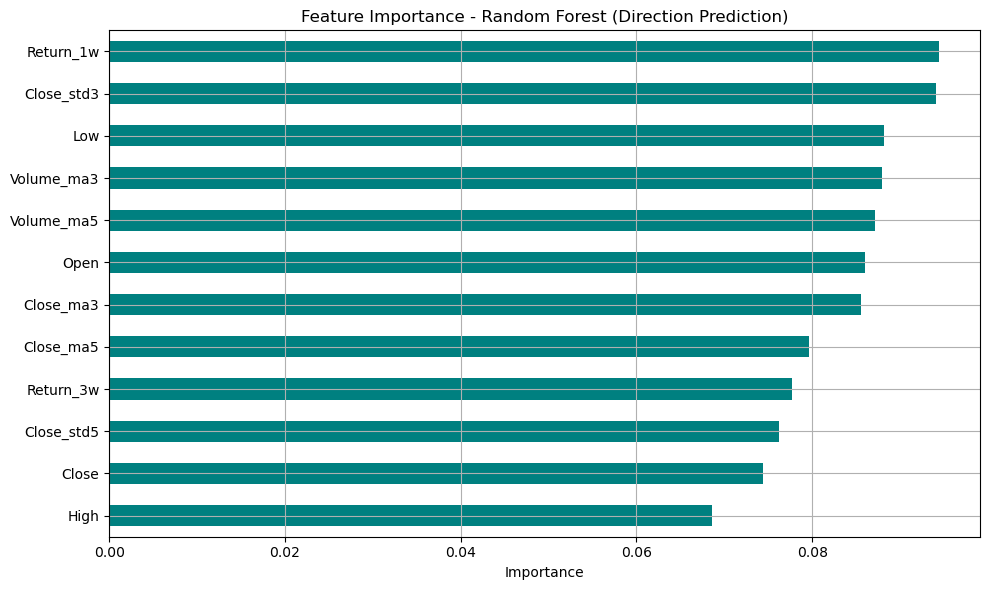

In [34]:
importances = pd.Series(best_rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Feature Importance - Random Forest (Direction Prediction)')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()